In [1]:
# set work dir
import os
os.chdir("../pkg")

In [2]:
import time
import pyepo
import torch
from matplotlib import pyplot as plt
plt.style.reload_library()
plt.style.use("science")
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Init Data

In [3]:
# generate data for grid network (features and costs)
m = 16 # number of items
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
dim = 3 # dimension of knapsack
cap = [10] * dim # capacity
weights, x, c = pyepo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=dim)

In [4]:
weights

array([[4.59, 4.87, 5.19, 7.59, 6.8 , 4.97, 4.84, 3.22, 7.9 , 3.62, 3.12,
        6.81, 7.09, 3.23, 4.47, 5.23],
       [6.11, 5.23, 4.27, 6.66, 5.21, 3.72, 7.83, 5.64, 7.56, 3.28, 4.31,
        3.85, 6.43, 4.26, 7.56, 6.4 ],
       [6.09, 6.4 , 4.5 , 6.31, 6.35, 3.07, 6.03, 7.39, 3.48, 5.57, 6.27,
        4.55, 5.64, 5.66, 3.27, 6.68]])

## Optimization Model 

In [5]:
#ks_model = pyepo.model.omo.knapsackModel(weights, cap, solver="gurobi")
ks_model = pyepo.model.omo.knapsackModel(weights, cap, solver="glpk")

Solver in the background: glpk


In [6]:
# solve
ks_model.setObj([i for i in range(m)])
sol, obj = ks_model.solve()
print(sol)
print("Obj: {}".format(obj))
for i in ks_model.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Obj: 18.0
5
13


In [7]:
# relax
ks_model_rel = ks_model.relax()

Solver in the background: glpk


In [8]:
# solve
ks_model_rel.setObj([i for i in range(m)])
sol, obj = ks_model_rel.solve()
print(sol)
print("Obj: {}".format(obj))
for i in ks_model_rel.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75825065494684, 0.0, 0.913521784638344, 0.421842880409434, 0.0]
Obj: 26.12234073044579
11
13
14


## Data Loader 

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [10]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [11]:
# get training data set
ks_dataset_train = pyepo.data.dataset.optDataset(ks_model, x_train, c_train)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 22.20it/s]


In [12]:
# get training data set for relaxation
ks_dataset_train_rel = pyepo.data.dataset.optDataset(ks_model_rel, x_train, c_train)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 21.93it/s]


In [13]:
# get test data set
ks_dataset_test = pyepo.data.dataset.optDataset(ks_model, x_test, c_test)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 22.19it/s]


In [14]:
# get data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_train_rel = DataLoader(ks_dataset_train_rel, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)

In [15]:
for i, data in enumerate(ks_loader_train):
    x, c, w, z = data
    break

In [16]:
x.shape

torch.Size([32, 5])

In [17]:
c.shape

torch.Size([32, 16])

In [18]:
w.shape

torch.Size([32, 16])

In [19]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [22]:
# build model
twostage_model = pyepo.twostage.sklearnPred(reg)

In [23]:
# training
twostage_model.fit(ks_dataset_train.feats, ks_dataset_train.costs)

MultiOutputRegressor(estimator=LinearRegression())

In [24]:
# prediction
c_test_pred = twostage_model.predict(ks_dataset_test.feats)

In [25]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.costs[i]
    z_true_i = ks_dataset_test.objs[i,0]
    truespo += pyepo.metric.calRegret(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += pyepo.metric.calUnambRegret(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print("Normalized Regret: {:.2f}%".format(truespo / abs(ks_dataset_test.objs.sum()) * 100))
print("Normalized Unambiguous Regret: {:.2f}%".format(unambspo / abs(ks_dataset_test.objs.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:16<00:00,  7.32it/s]


Normalized Regret: 2.01%
Normalized Unambiguous Regret: 2.01%


In [26]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 9.00, 3.00, 7.00, 3.00, 4.00, 4.00, 5.00, 3.00, 2.00, 6.00, 7.00, 3.00, 4.00, 2.00, 4.00, 2.00
    Pred cost: 8.42, 3.70, 6.85, 4.64, 4.61, 4.61, 6.97, 3.00, 2.97, 6.70, 6.85, 4.86, 4.61, 3.13, 4.28, 2.97
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 13.00
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 13.00

Sample 1:
    True cost: 5.00, 2.00, 5.00, 4.00, 4.00, 4.00, 3.00, 3.00, 2.00, 3.00, 5.00, 1.00, 4.00, 2.00, 2.00, 2.00
    Pred cost: 6.09, 1.42, 5.24, 4.79, 4.39, 4.39, 4.58, 3.00, 2.48, 3.68, 5.24, 0.58, 4.39, 2.94, 2.81, 2.48
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 9.00
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 9.00

Sample 2:
    True cost: 21.00, 3.00, 10.00, 9.00, 9.00, 9.00, 13.00, 3.00, 4.00, 11.00, 10.00, 8.00, 9.00, 5.00, 9.00, 4.00
    Pred cost: 13.13, 3.23, 8.72, 9.15, 7.64, 7.64, 11.83, 3.00, 5.28, 9.20, 8.72, 8.83, 7.64, 6.22, 7.

## Linear Regression from PyTorch

In [27]:
from torch import nn

In [28]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [29]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [30]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-3)

In [31]:
# init SPO+ loss
criterion = pyepo.func.SPOPlus(ks_model, processes=4)

Num of cores: 4


In [32]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:   8.8557, Regret: 19.4759%, Unambiguous Regret: 19.4759%
Epoch  20, Loss:   4.0390, Regret:  5.3291%, Unambiguous Regret:  5.3291%
Epoch  30, Loss:   3.0701, Regret:  2.0335%, Unambiguous Regret:  2.0335%
Epoch  40, Loss:   0.7940, Regret:  0.9116%, Unambiguous Regret:  0.9116%
Epoch  50, Loss:   1.2290, Regret:  0.6311%, Unambiguous Regret:  0.6311%
Epoch  60, Loss:   3.6109, Regret:  0.5610%, Unambiguous Regret:  0.5610%
Epoch  70, Loss:   0.7329, Regret:  0.5522%, Unambiguous Regret:  0.5522%
Epoch  80, Loss:   0.3039, Regret:  0.3944%, Unambiguous Regret:  0.3944%
Epoch  90, Loss:   0.4530, Regret:  0.2279%, Unambiguous Regret:  0.2279%
Epoch 100, Loss:   0.5726, Regret:  0.3331%, Unambiguous Regret:  0.3331%
Epoch 110, Loss:   0.1547, Regret:  0.2892%, Unambiguous Regret:  0.2892%
Epoch 120, Loss:   0.1395, Regret:  0.4207%, Unambiguous Regret:  0.4207%
Epoch 130, Loss:   0.2758, Regret:  0.2630%, Unambiguous Regret:  0.2630%
Epoch 140, Loss:   1.1518, Regret:  0.

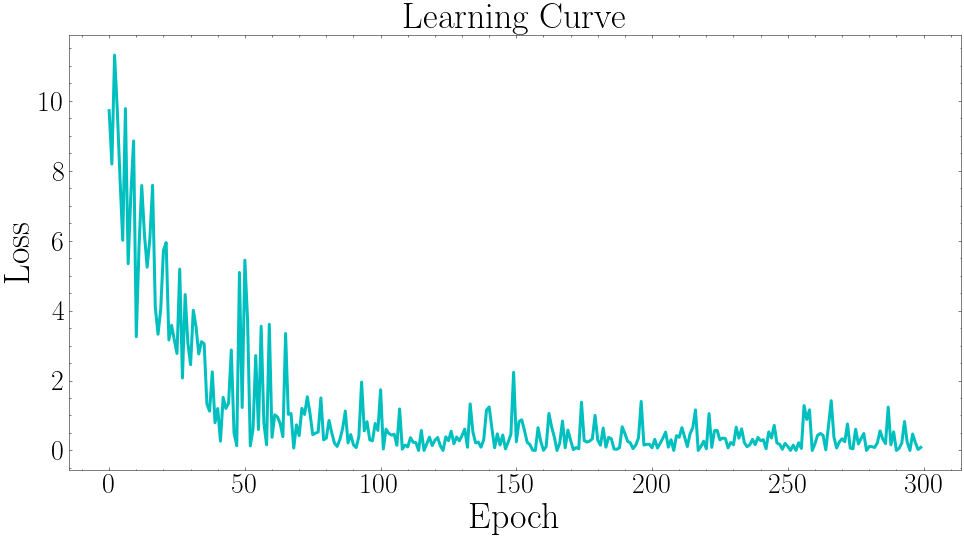

In [33]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

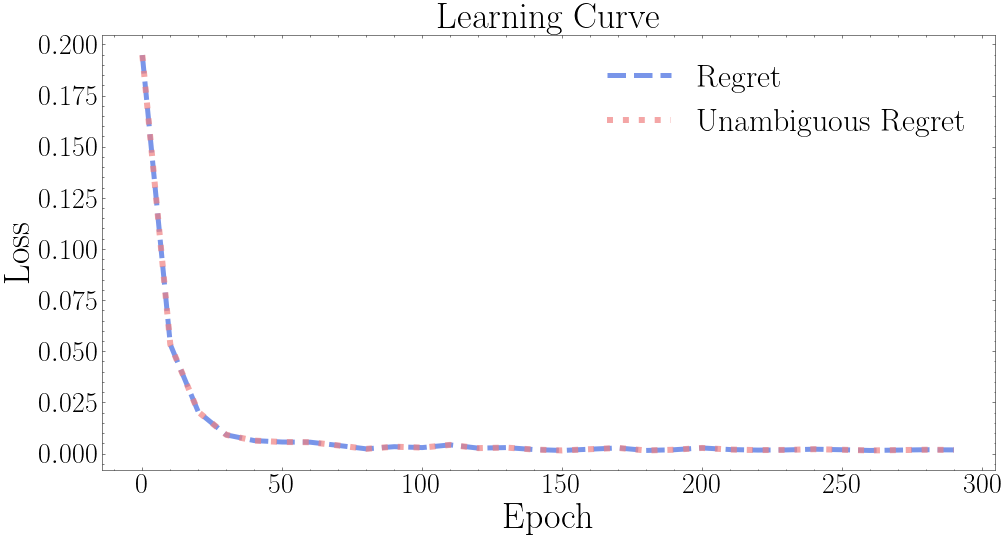

In [34]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [35]:
# evaluate
spoloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 0.18%
Normalized Unambiguous Regret: 0.18%


In [36]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 9.00, 3.00, 7.00, 3.00, 4.00, 4.00, 5.00, 3.00, 2.00, 6.00, 7.00, 3.00, 4.00, 2.00, 4.00, 2.00
    Pred cost: 8.27, 1.02, -0.36, 6.06, -0.05, 7.92, 8.52, 5.54, 4.25, 6.48, 6.96, 3.71, -0.98, 0.10, 6.32, 3.73
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 13.00
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 13.00

Sample 1:
    True cost: 5.00, 2.00, 5.00, 4.00, 4.00, 4.00, 3.00, 3.00, 2.00, 3.00, 5.00, 1.00, 4.00, 2.00, 2.00, 2.00
    Pred cost: 5.97, -1.62, -0.45, 6.53, -0.15, 6.86, 4.72, 4.55, 2.70, 3.25, 5.21, -3.53, -0.57, 1.29, 3.41, 2.95
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 9.00
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 9.00

Sample 2:
    True cost: 21.00, 3.00, 10.00, 9.00, 9.00, 9.00, 13.00, 3.00, 4.00, 11.00, 10.00, 8.00, 9.00, 5.00, 9.00, 4.00
    Pred cost: 11.94, -3.98, -0.83, 7.32, -0.42, 7.40, 10.12, -0.17, 0.34, 6.57, 6.51, 4.18, -0

## SPO+ Rel 

In [37]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [38]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-3)

In [39]:
# init SPO+ loss
criterion = pyepo.func.SPOPlus(ks_model_rel, processes=4)

Num of cores: 4


In [40]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train_rel):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  11.0464, Regret: 11.0702%, Unambiguous Regret: 11.0702%
Epoch  20, Loss:   5.7828, Regret:  3.1028%, Unambiguous Regret:  3.1028%
Epoch  30, Loss:   0.7947, Regret:  1.9283%, Unambiguous Regret:  1.9283%
Epoch  40, Loss:   0.7500, Regret:  1.1657%, Unambiguous Regret:  1.1657%
Epoch  50, Loss:   0.4255, Regret:  0.8064%, Unambiguous Regret:  0.8064%
Epoch  60, Loss:   0.9462, Regret:  0.7100%, Unambiguous Regret:  0.7100%
Epoch  70, Loss:   0.2100, Regret:  0.6311%, Unambiguous Regret:  0.6311%
Epoch  80, Loss:   0.3012, Regret:  0.6223%, Unambiguous Regret:  0.6223%
Epoch  90, Loss:   0.3219, Regret:  0.5434%, Unambiguous Regret:  0.5434%
Epoch 100, Loss:   0.3925, Regret:  0.4996%, Unambiguous Regret:  0.4996%
Epoch 110, Loss:   0.3192, Regret:  0.4821%, Unambiguous Regret:  0.4821%
Epoch 120, Loss:   0.4181, Regret:  0.4996%, Unambiguous Regret:  0.4996%
Epoch 130, Loss:   0.2093, Regret:  0.3944%, Unambiguous Regret:  0.3944%
Epoch 140, Loss:   0.1019, Regret:  0.

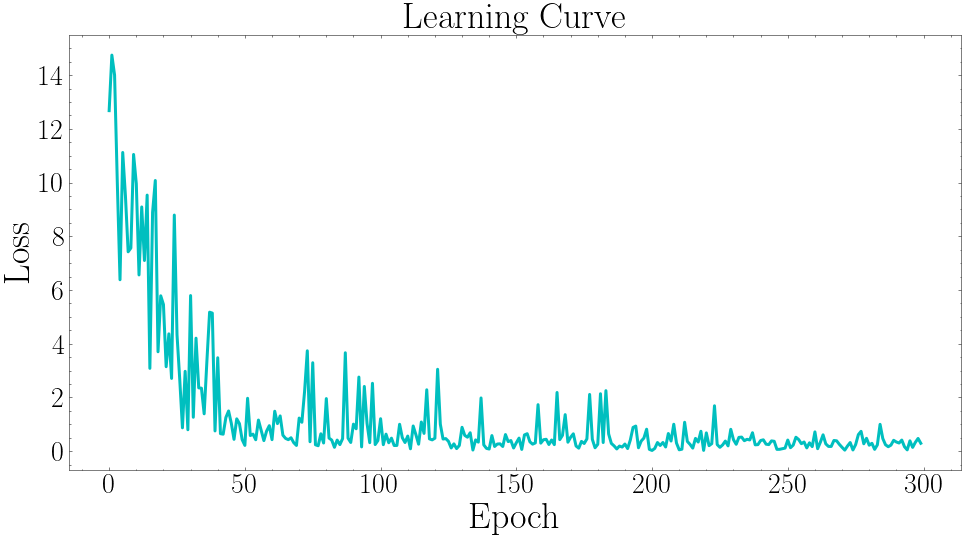

In [41]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

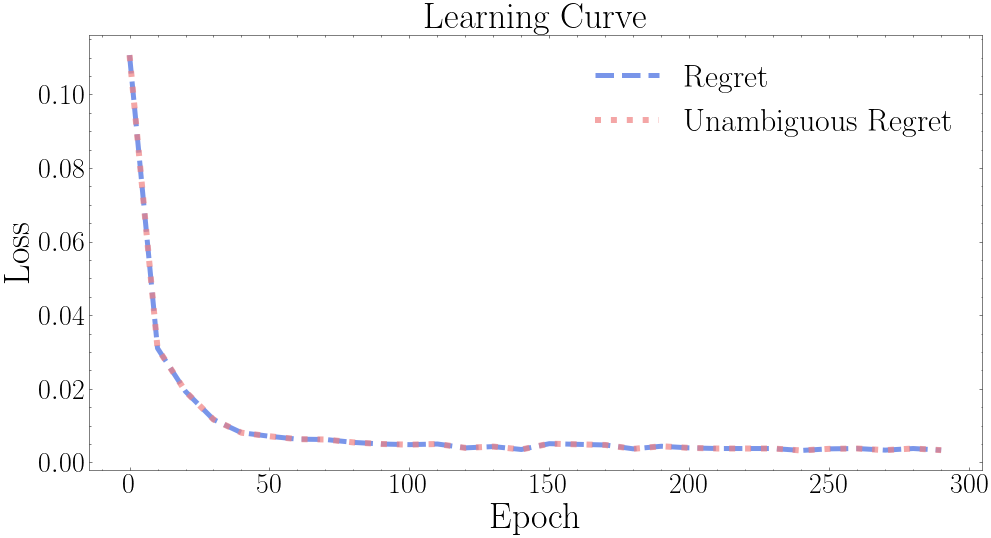

In [42]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [43]:
# evaluate
spoloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 0.33%
Normalized Unambiguous Regret: 0.33%


In [44]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 9.00, 3.00, 7.00, 3.00, 4.00, 4.00, 5.00, 3.00, 2.00, 6.00, 7.00, 3.00, 4.00, 2.00, 4.00, 2.00
    Pred cost: 9.74, 1.95, 7.64, 2.86, 4.25, 4.70, 5.99, 2.22, 0.34, 7.64, 8.23, 2.81, 4.66, 1.25, 4.06, -0.05
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 13.00
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 13.00

Sample 1:
    True cost: 5.00, 2.00, 5.00, 4.00, 4.00, 4.00, 3.00, 3.00, 2.00, 3.00, 5.00, 1.00, 4.00, 2.00, 2.00, 2.00
    Pred cost: 6.70, -1.36, 5.99, 4.16, 5.01, 4.98, 3.03, 3.52, 1.01, 3.86, 6.31, -2.92, 5.05, 2.08, 2.77, 0.54
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 9.00
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 9.00

Sample 2:
    True cost: 21.00, 3.00, 10.00, 9.00, 9.00, 9.00, 13.00, 3.00, 4.00, 11.00, 10.00, 8.00, 9.00, 5.00, 9.00, 4.00
    Pred cost: 12.84, -3.70, 6.75, 5.67, 5.18, 5.73, 9.17, -1.64, -0.31, 7.56, 6.96, 4.50, 5.68, 2.0

## Black-Box

In [45]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [46]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [47]:
# set loss
bb = pyepo.func.blackboxOpt(ks_model, lambd=20, processes=4)
criterion = nn.L1Loss()

Num of cores: 4


In [48]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = bb.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:   2.1250, Regret: 20.3261%, Unambiguous Regret: 20.3261%
Epoch  20, Loss:   1.1250, Regret: 14.4535%, Unambiguous Regret: 14.4535%
Epoch  30, Loss:   1.2500, Regret: 13.8750%, Unambiguous Regret: 13.8750%
Epoch  40, Loss:   1.0000, Regret: 13.8925%, Unambiguous Regret: 13.8925%
Epoch  50, Loss:   1.8750, Regret: 13.8312%, Unambiguous Regret: 13.8312%
Epoch  60, Loss:   0.6250, Regret: 13.6822%, Unambiguous Regret: 13.6822%
Epoch  70, Loss:   1.6250, Regret: 13.6822%, Unambiguous Regret: 13.6822%
Epoch  80, Loss:   2.5000, Regret: 13.7961%, Unambiguous Regret: 13.7961%
Epoch  90, Loss:   0.6250, Regret: 13.8137%, Unambiguous Regret: 13.8137%
Epoch 100, Loss:   0.7500, Regret: 13.7260%, Unambiguous Regret: 13.7260%
Epoch 110, Loss:   1.3750, Regret: 13.9276%, Unambiguous Regret: 13.9276%
Epoch 120, Loss:   1.3750, Regret: 14.0678%, Unambiguous Regret: 14.0678%
Epoch 130, Loss:   0.8750, Regret: 14.1292%, Unambiguous Regret: 14.1292%
Epoch 140, Loss:   1.8750, Regret: 14.

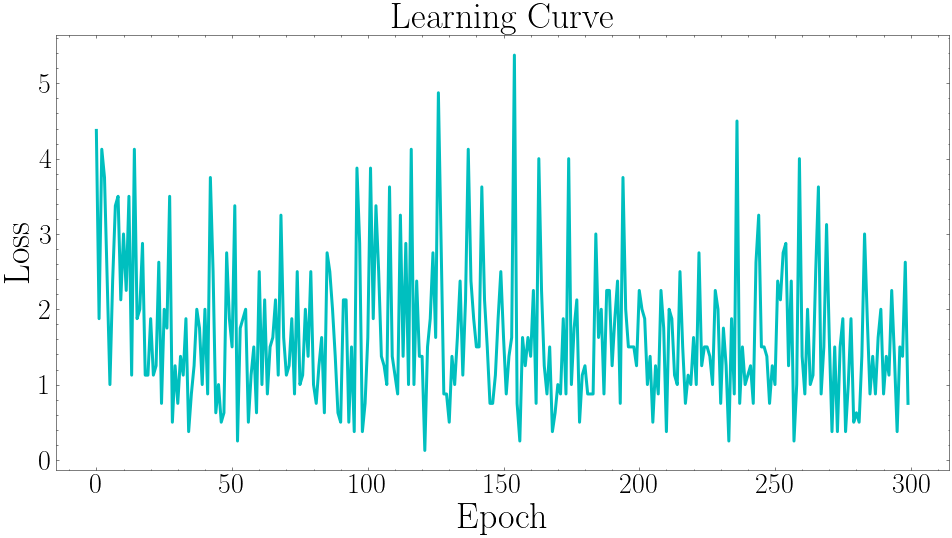

In [49]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

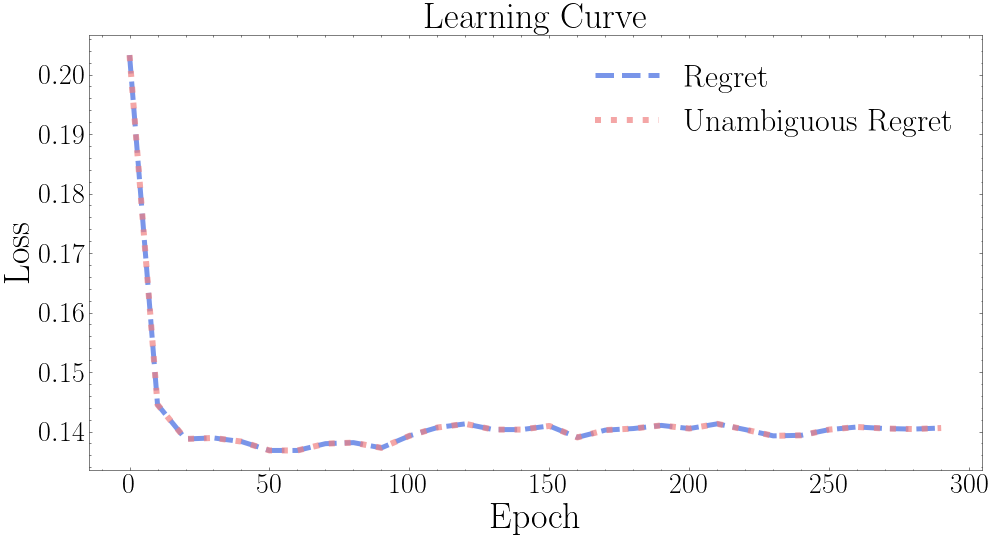

In [50]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [51]:
# evaluate
spoloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 14.06%
Normalized Unambiguous Regret: 14.06%


In [52]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 9.00, 3.00, 7.00, 3.00, 4.00, 4.00, 5.00, 3.00, 2.00, 6.00, 7.00, 3.00, 4.00, 2.00, 4.00, 2.00
    Pred cost: 24.65, 2.62, 0.02, -0.29, 0.10, 15.67, 7.58, 0.81, -2.75, 0.14, -0.56, 0.15, -0.16, -1.02, 5.66, -0.85
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 13.00
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 13.00

Sample 1:
    True cost: 5.00, 2.00, 5.00, 4.00, 4.00, 4.00, 3.00, 3.00, 2.00, 3.00, 5.00, 1.00, 4.00, 2.00, 2.00, 2.00
    Pred cost: 19.84, -3.39, -0.66, -0.29, 0.03, 13.95, 2.68, 0.97, -2.10, -0.20, -0.59, -0.01, -0.00, 2.64, -0.10, -0.83
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 9.00
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 9.00

Sample 2:
    True cost: 21.00, 3.00, 10.00, 9.00, 9.00, 9.00, 13.00, 3.00, 4.00, 11.00, 10.00, 8.00, 9.00, 5.00, 9.00, 4.00
    Pred cost: 38.90, -7.39, -0.03, -0.74, 0.11, 21.72, 17.79, 1.51, 2.98, 0.87, -0